In [1]:
# std
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import os
import re
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor

# img viz
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# img proc
import cv2
from skimage import color, io

# ml
import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

# torch
import torch
from torch import nn
from torch.optim import Adam
import torch.nn.functional as F
import torchvision
from torchvision.io import read_image, ImageReadMode
from torch.utils.data import Dataset, DataLoader

# KNN, RandomForest, DecisionTree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Dataset

In [3]:
class PlantDataset(Dataset):
    """Load images as needed. Directory must be placed as: datadir/split/category/*.png"""
    def __init__(self,
                 datadir='/content/drive/MyDrive/Tomato Leaf Disease Classification/final_dataset',
                 split='train',
                 fmt='np'):
        # store image list from disk
        self.im_paths = sorted(glob.glob(os.path.join(datadir, split, '**/*.png')))
        # store the labels and create lookup for easy retrieval
        self.lbl_list = list(map(lambda lbl: lbl.split(os.path.sep)[-2].lower(), self.im_paths))
        self.lbl_cat_lkp = {e: i for i, e in enumerate(sorted(list(set(self.lbl_list))))}
        self.cat_lbl_lkp = {i: e for e, i in self.lbl_cat_lkp.items()}
        self.cat = np.array([self.lbl_cat_lkp[e] for e in self.lbl_list])
        self.fmt=fmt
        self.split=split

    def get_impath(self, idx): return self.im_paths[idx]

    def __getitem__(self, idx):
        """Return processed image from file list"""
        if self.fmt=='torch':
            im_path = self.im_paths[idx]
            tim = read_image(im_path, ImageReadMode.RGB)
            return tim/255, self.cat[idx]
        elif self.fmt=='np':
            im_path = self.im_paths[idx]
            npim = plt.imread(im_path)[..., :3] # remove alpha channel
            return npim, self.cat[idx]

    def __len__(self): return len(self.im_paths)

train_dset = PlantDataset()
print(f'>> Images on {train_dset.split}: {len(train_dset):,}')
print(pd.Series(train_dset.lbl_list).value_counts())

val_dset = PlantDataset(split='validation')
print(f'\n>> Images on {val_dset.split}: {len(val_dset):,}')
print(pd.Series(val_dset.lbl_list).value_counts())

test_dset = PlantDataset(split='test')
print(f'\n>> Images on {test_dset.split}: {len(test_dset):,}')
print(pd.Series(test_dset.lbl_list).value_counts())

print(f'\n>> Total images: {len(test_dset) + len(val_dset) + len(train_dset):,}')

>> Images on train: 14,523
tomato_yellow_leaf_curl_virus           4285
bacterial_spot                          1701
late_blight                             1527
septoria_leaf_spot                      1416
spider_mites_two-spotted_spider_mite    1340
healthy                                 1272
target_spot                             1123
early_blight                             800
leaf_mold                                761
tomato_mosaic_virus                      298
dtype: int64

>> Images on validation: 1,812
tomato_yellow_leaf_curl_virus           535
bacterial_spot                          212
late_blight                             190
septoria_leaf_spot                      177
spider_mites_two-spotted_spider_mite    167
healthy                                 159
target_spot                             140
early_blight                            100
leaf_mold                                95
tomato_mosaic_virus                      37
dtype: int64

>> Images on test: 1,824

In [4]:
train_dset.lbl_cat_lkp

{'bacterial_spot': 0,
 'early_blight': 1,
 'healthy': 2,
 'late_blight': 3,
 'leaf_mold': 4,
 'septoria_leaf_spot': 5,
 'spider_mites_two-spotted_spider_mite': 6,
 'target_spot': 7,
 'tomato_mosaic_virus': 8,
 'tomato_yellow_leaf_curl_virus': 9}

In [5]:
val_dset.lbl_cat_lkp

{'bacterial_spot': 0,
 'early_blight': 1,
 'healthy': 2,
 'late_blight': 3,
 'leaf_mold': 4,
 'septoria_leaf_spot': 5,
 'spider_mites_two-spotted_spider_mite': 6,
 'target_spot': 7,
 'tomato_mosaic_virus': 8,
 'tomato_yellow_leaf_curl_virus': 9}

In [6]:
test_dset.lbl_cat_lkp

{'bacterial_spot': 0,
 'early_blight': 1,
 'healthy': 2,
 'late_blight': 3,
 'leaf_mold': 4,
 'septoria_leaf_spot': 5,
 'spider_mites_two-spotted_spider_mite': 6,
 'target_spot': 7,
 'tomato_mosaic_virus': 8,
 'tomato_yellow_leaf_curl_virus': 9}

## Dim Reduction

### PCA

In [7]:
def displayPca(x_train):

  nc = 100
  pca = PCA(n_components=nc)
  X_train_pca = pca.fit_transform(x_train)

  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

  # variance ratio % per PC
  sns.lineplot(x=np.arange(100), y=np.cumsum(pca.explained_variance_ratio_), ax=ax[0])
  ax[0].set_title(f'Pct Variance Explained for {nc} PCs: {pca.explained_variance_ratio_.sum():.0%}')

  # scatter of 2 PCs
  scatter = ax[1].scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=Y_train, alpha=0.5)
  legend1 = ax[1].legend(*scatter.legend_elements(), title="Classes")
  ax[1].add_artist(legend1)
  ax[1].set_title('Scatter of First 2 PCs')

  plt.show()

  return pca, X_train_pca

### TSNE

In [8]:
def displayTsne(x_train):
  tsne = TSNE(n_components=2)
  X_tsne = tsne.fit_transform(x_train)
  fig, ax = plt.subplots()
  scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=Y_train, alpha=0.5)
  legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
  ax.set_title('First 2 components of t-SNE')
  plt.show()

## Classifiers

In [9]:
def plot_train_val_loss(history_dict):
  df = pd.DataFrame(history_dict)
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
  ax[0].plot(history_dict['loss'], 'b-o')
  ax[0].plot(history_dict['val_loss'], 'r-o')
  ax[0].legend(['loss', 'val_loss'])
  ax[0].set_title('Loss')

  ax[1].plot(history_dict['accuracy'], 'b-o')
  ax[1].plot(history_dict['val_accuracy'], 'r-o')
  ax[1].legend(['accuracy', 'val_accuracy'])
  ax[1].set_title('Accuracy')
  plt.show()

### Logistic Regression

In [10]:
class LogisticRegression(keras.Model):
  def __init__(self, name='logistic_regression'):
    super().__init__(name=name)
    self.lr = keras.layers.Dense(units=10, activation='softmax', name='lr')

  def call(self, inputs, training=False):
    return self.lr(inputs)

def performLogisticRegression(x_train, y_train, x_val, y_val):
  model = LogisticRegression()
  es_callback = EarlyStopping(monitor='val_loss', patience=5)
  model.compile(
      loss=keras.losses.SparseCategoricalCrossentropy(),
      optimizer=keras.optimizers.Adam(),
      metrics=['accuracy']
  )

  history = model.fit(
      x_train, y_train,
      batch_size=64,
      epochs=150,
      validation_data=(x_val, y_val),
      callbacks=[es_callback]
  )

  plot_train_val_loss(history.history)

  return model

### FeatureNet

In [11]:
class FeatureNet(keras.Model):
  def __init__(self, name='features_model'):
    super().__init__(name=name)
    # self.inputs = keras.Input(shape=(ndims,))
    self.dense1 = keras.layers.Dense(units=512, activation='relu', name='dense1')
    self.dropout1 = keras.layers.Dropout(.25)
    self.dense2 = keras.layers.Dense(units=256, activation='relu', name='dense2')
    self.dropout2 = keras.layers.Dropout(.2)
    self.dense3 = keras.layers.Dense(units=64, activation='relu', name='dense3')
    self.dropout3 = keras.layers.Dropout(.2)
    self.out = keras.layers.Dense(units=10, activation='softmax', name='softmax')

  def call(self, inputs, training=False):
    x = self.dense1(inputs)
    x = self.dropout1(x)
    x = self.dense2(x)
    x = self.dropout2(x)
    x = self.dense3(x)
    return self.out(x)

def performFeatureNet(x_train, y_train, x_val, y_val):
  model = FeatureNet()
  es_callback = EarlyStopping(monitor='val_loss', patience=3)
  model.compile(
      loss=keras.losses.SparseCategoricalCrossentropy(),
      optimizer=keras.optimizers.Adam(),
      metrics=['accuracy']
  )

  history = model.fit(
      x_train, y_train,
      batch_size=64,
      epochs=20,
      validation_data=(x_val, y_val),
      callbacks=[es_callback]
  )

  plot_train_val_loss(history.history)

  return model

### KNN


In [12]:
def performKnn(x_train, y_train, x_val, y_val):

  knn = KNeighborsClassifier()
  knn.fit(x_train, y_train)

  y_train_pred = knn.predict(x_train)

  # Predict on the validation set
  y_val_pred = knn.predict(x_val)

  # Calculate accuracy for training and validation sets
  train_accuracy = accuracy_score(y_train, y_train_pred)
  val_accuracy = accuracy_score(y_val, y_val_pred)

  print(f"Training Accuracy: {train_accuracy:.2f}")
  print(f"Validation Accuracy: {val_accuracy:.2f}")

  return knn

### Random Forest


In [13]:
def performRandomForest(x_train, y_train, x_val, y_val):

  clf = RandomForestClassifier()
  clf.fit(x_train, y_train)

  y_train_pred = clf.predict(x_train)

  # Predict on the validation set
  y_val_pred = clf.predict(x_val)

  # Calculate accuracy for training and validation sets
  train_accuracy = accuracy_score(y_train, y_train_pred)
  val_accuracy = accuracy_score(y_val, y_val_pred)

  print(f"Training Accuracy: {train_accuracy:.2f}")
  print(f"Validation Accuracy: {val_accuracy:.2f}")

  return clf

### Decision Tree

In [14]:
def performDecisionTree(x_train, y_train, x_val, y_val):

  dt = DecisionTreeClassifier()
  dt.fit(x_train, y_train)

  y_train_pred = dt.predict(x_train)

  # Predict on the validation set
  y_val_pred = dt.predict(x_val)

  # Calculate accuracy for training and validation sets
  train_accuracy = accuracy_score(y_train, y_train_pred)
  val_accuracy = accuracy_score(y_val, y_val_pred)

  print(f"Training Accuracy: {train_accuracy:.2f}")
  print(f"Validation Accuracy: {val_accuracy:.2f}")

  return dt

## Train + Validation Peformance of Various Feature Vectors

In [15]:
def read_features_from_files(file_list):
  feats = [pd.read_csv(f).values for f in file_list]
  return np.concatenate(feats, axis=1).astype(np.float32)

### RGB vs LAB

In [16]:
Y_train = train_dset.cat
Y_val = val_dset.cat
Y_test = test_dset.cat

In [17]:
X_rgb_train = read_features_from_files([
    '/content/drive/MyDrive/Tomato Leaf Disease Classification/features/train_rgbhist_b100_r0-1_prob.csv'
])
print('Train:', X_rgb_train.shape, Y_train.shape)

X_rgb_val = read_features_from_files([
    '/content/drive/MyDrive/Tomato Leaf Disease Classification/features/val_rgbhist_b100_r0-1_prob.csv'
])
print('Validation:', X_rgb_val.shape, Y_val.shape)

X_rgb_test = read_features_from_files([
    '/content/drive/MyDrive/Tomato Leaf Disease Classification/features/test_rgbhist_b100_r0-1_prob.csv'
])
print('Test:', X_rgb_test.shape, Y_test.shape)

Train: (14523, 300) (14523,)
Validation: (1812, 300) (1812,)
Test: (1824, 300) (1824,)


In [18]:
X_lab_train = read_features_from_files([
    '/content/drive/MyDrive/Tomato Leaf Disease Classification/features/train_labhist_b100_prob.csv'
])
print('Train:', X_lab_train.shape, Y_train.shape)

X_lab_val = read_features_from_files([
    '/content/drive/MyDrive/Tomato Leaf Disease Classification/features/val_labhist_b100_prob.csv'
])
print('Validation:', X_lab_val.shape, Y_val.shape)

X_lab_test = read_features_from_files([
    '/content/drive/MyDrive/Tomato Leaf Disease Classification/features/test_labhist_b100_prob.csv'
])
print('Test:', X_lab_test.shape, Y_test.shape)

Train: (14523, 300) (14523,)
Validation: (1812, 300) (1812,)
Test: (1824, 300) (1824,)


#### Train + Validation Performance of RGB

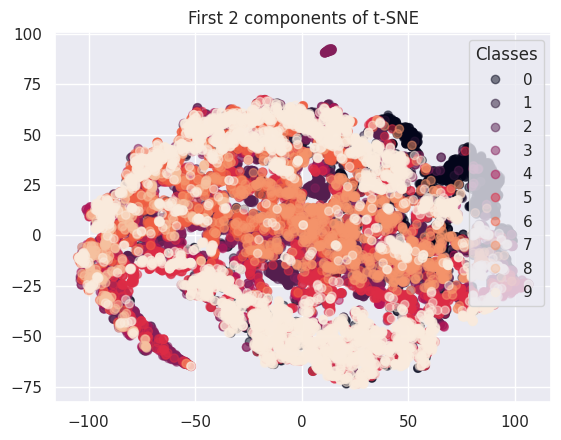

In [19]:
displayTsne(X_rgb_train)

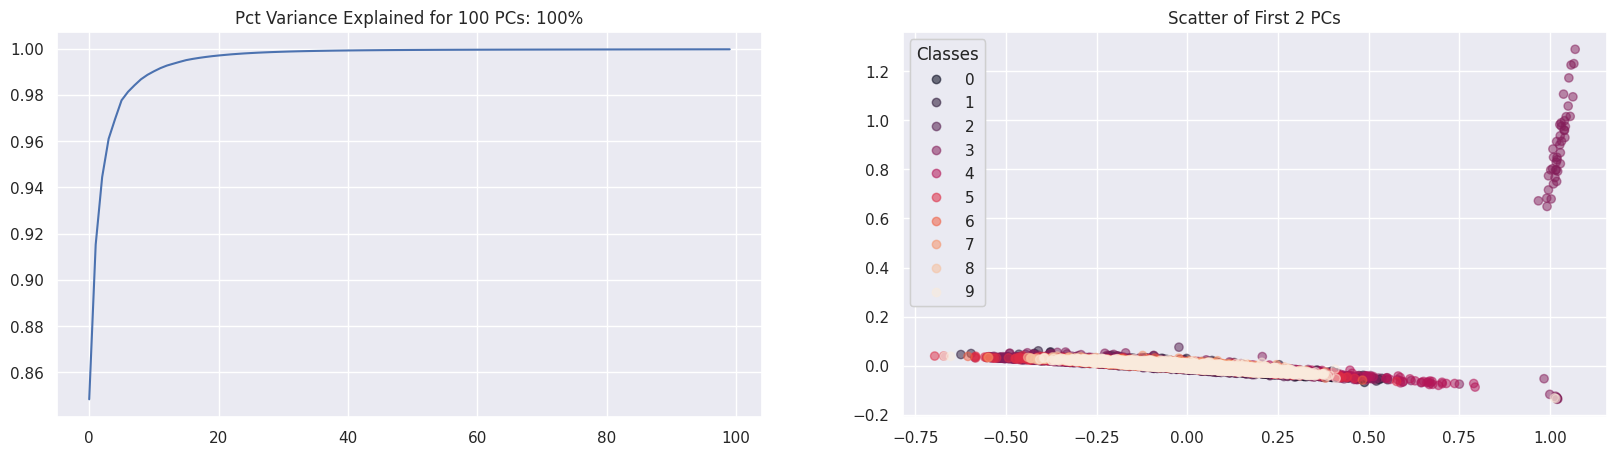

In [20]:
rgb_pca, X_rgb_train_pca = displayPca(X_rgb_train)
X_rgb_val_pca = rgb_pca.transform(X_rgb_val)

Epoch 1/150
227/227 [==============================] - 1s 3ms/step - loss: 2.1865 - accuracy: 0.2703 - val_loss: 2.1000 - val_accuracy: 0.2953
Epoch 2/150
227/227 [==============================] - 0s 2ms/step - loss: 2.0661 - accuracy: 0.2950 - val_loss: 2.0384 - val_accuracy: 0.2953
Epoch 3/150
227/227 [==============================] - 0s 2ms/step - loss: 2.0204 - accuracy: 0.2950 - val_loss: 1.9995 - val_accuracy: 0.2953
Epoch 4/150
227/227 [==============================] - 0s 2ms/step - loss: 1.9844 - accuracy: 0.2965 - val_loss: 1.9653 - val_accuracy: 0.3019
Epoch 5/150
227/227 [==============================] - 0s 2ms/step - loss: 1.9520 - accuracy: 0.3130 - val_loss: 1.9337 - val_accuracy: 0.3273
Epoch 6/150
227/227 [==============================] - 0s 2ms/step - loss: 1.9220 - accuracy: 0.3357 - val_loss: 1.9046 - val_accuracy: 0.3499
Epoch 7/150
227/227 [==============================] - 0s 2ms/step - loss: 1.8942 - accuracy: 0.3564 - val_loss: 1.8777 - val_accuracy: 0.3653

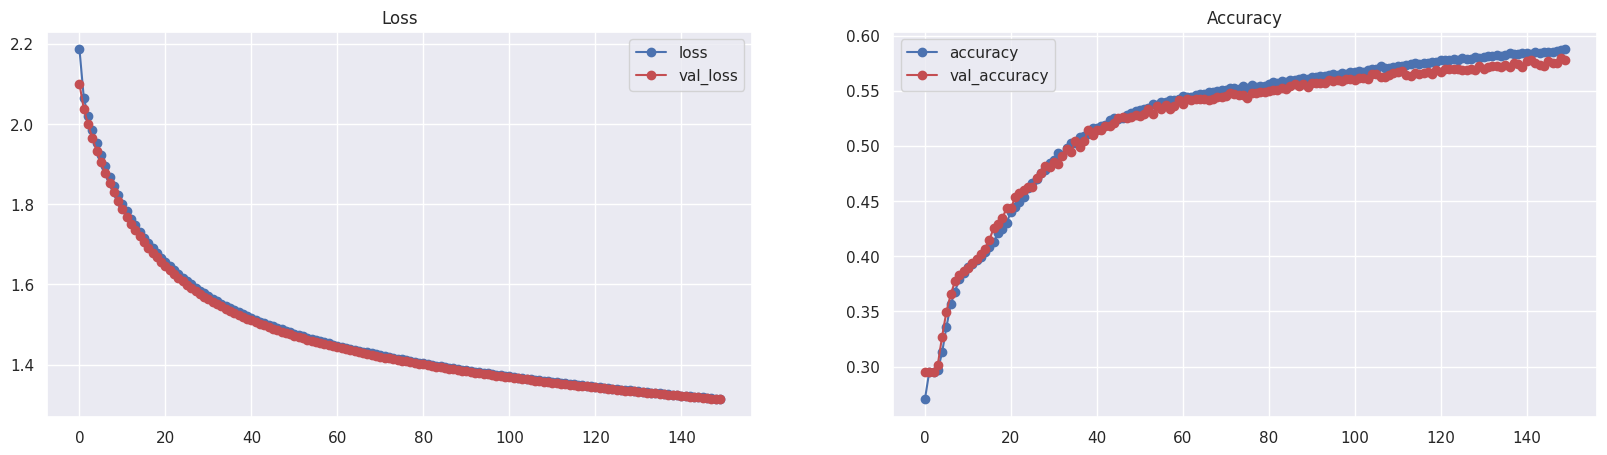

In [21]:
logistic_model_rgb = performLogisticRegression(X_rgb_train, Y_train, X_rgb_val, Y_val)

Epoch 1/20
227/227 [==============================] - 4s 14ms/step - loss: 1.7984 - accuracy: 0.3974 - val_loss: 1.4383 - val_accuracy: 0.5248
Epoch 2/20
227/227 [==============================] - 2s 11ms/step - loss: 1.3206 - accuracy: 0.5525 - val_loss: 1.2062 - val_accuracy: 0.5866
Epoch 3/20
227/227 [==============================] - 2s 9ms/step - loss: 1.1767 - accuracy: 0.5962 - val_loss: 1.1296 - val_accuracy: 0.6026
Epoch 4/20
227/227 [==============================] - 2s 9ms/step - loss: 1.0893 - accuracy: 0.6267 - val_loss: 0.9828 - val_accuracy: 0.6716
Epoch 5/20
227/227 [==============================] - 2s 8ms/step - loss: 1.0345 - accuracy: 0.6461 - val_loss: 0.9410 - val_accuracy: 0.6749
Epoch 6/20
227/227 [==============================] - 2s 8ms/step - loss: 0.9845 - accuracy: 0.6642 - val_loss: 0.9276 - val_accuracy: 0.6650
Epoch 7/20
227/227 [==============================] - 2s 10ms/step - loss: 0.9491 - accuracy: 0.6759 - val_loss: 0.8643 - val_accuracy: 0.7092
Epo

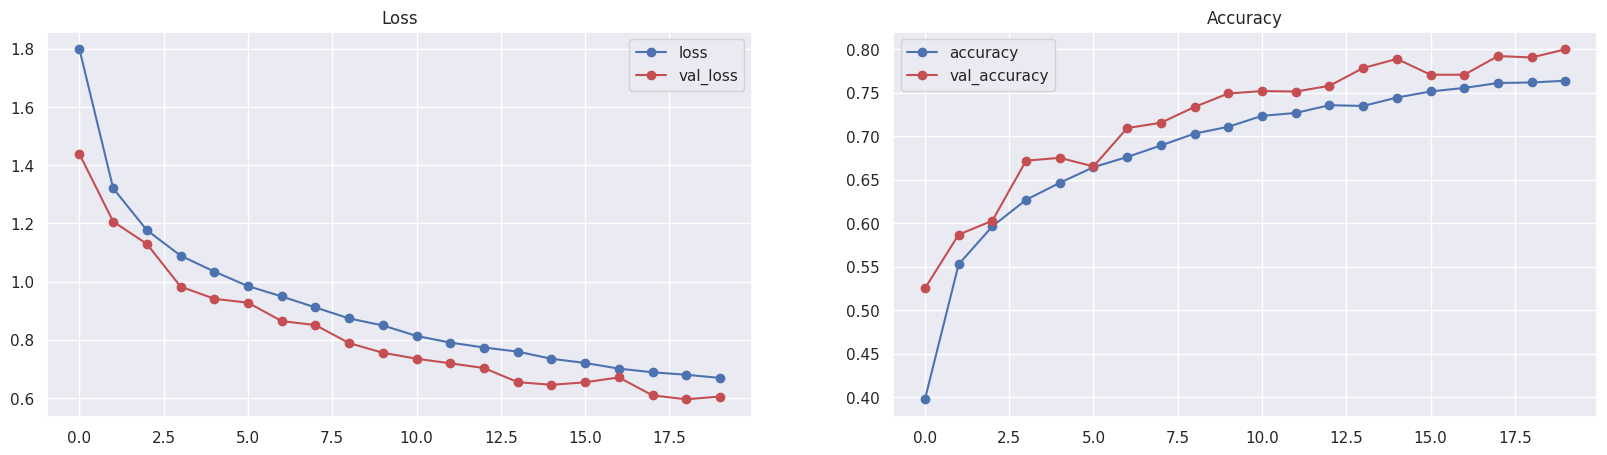

In [22]:
featurenet_model_rgb = performFeatureNet(X_rgb_train, Y_train, X_rgb_val, Y_val)

In [23]:
knn_model_rgb = performKnn(X_rgb_train, Y_train, X_rgb_val, Y_val)

Training Accuracy: 0.79
Validation Accuracy: 0.68


In [24]:
randomforest_model_rgb = performRandomForest(X_rgb_train, Y_train, X_rgb_val, Y_val)

Training Accuracy: 1.00
Validation Accuracy: 0.82


In [25]:
decisiontree_model_rgb = performDecisionTree(X_rgb_train, Y_train, X_rgb_val, Y_val)

Training Accuracy: 1.00
Validation Accuracy: 0.65


#### Train + Validation Performance of LAB

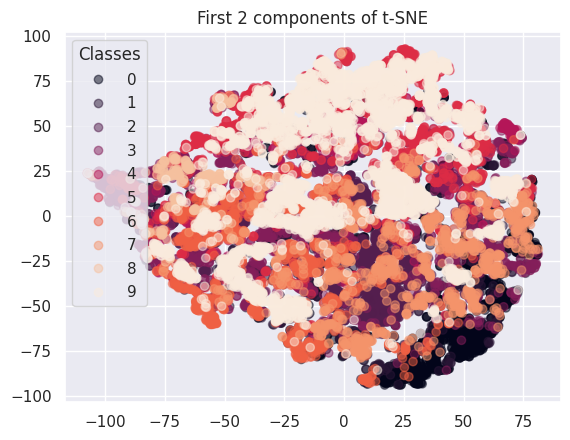

In [26]:
displayTsne(X_lab_train)

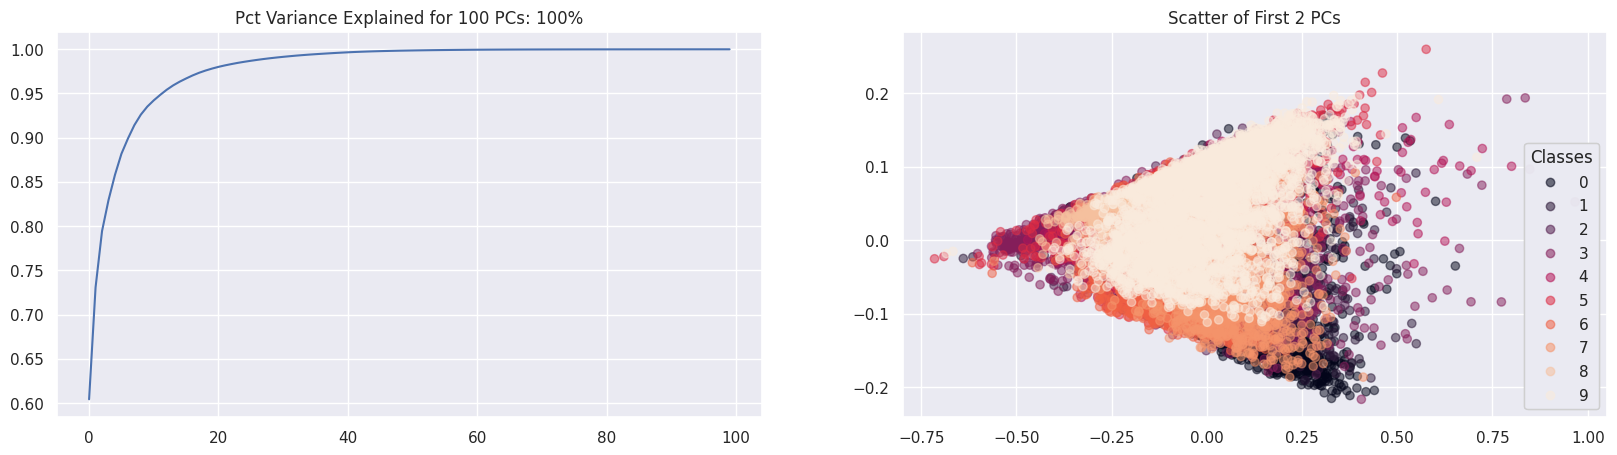

In [44]:
lab_pca, X_lab_train_pca = displayPca(X_lab_train)
X_lab_val_pca = lab_pca.transform(X_lab_val)

Epoch 1/150
227/227 [==============================] - 1s 3ms/step - loss: 2.1764 - accuracy: 0.2610 - val_loss: 2.0810 - val_accuracy: 0.2953
Epoch 2/150
227/227 [==============================] - 0s 2ms/step - loss: 2.0336 - accuracy: 0.2950 - val_loss: 1.9966 - val_accuracy: 0.2953
Epoch 3/150
227/227 [==============================] - 0s 2ms/step - loss: 1.9643 - accuracy: 0.2999 - val_loss: 1.9382 - val_accuracy: 0.3096
Epoch 4/150
227/227 [==============================] - 0s 2ms/step - loss: 1.9096 - accuracy: 0.3294 - val_loss: 1.8891 - val_accuracy: 0.3455
Epoch 5/150
227/227 [==============================] - 0s 2ms/step - loss: 1.8623 - accuracy: 0.3583 - val_loss: 1.8457 - val_accuracy: 0.3653
Epoch 6/150
227/227 [==============================] - 0s 2ms/step - loss: 1.8202 - accuracy: 0.3798 - val_loss: 1.8071 - val_accuracy: 0.3841
Epoch 7/150
227/227 [==============================] - 0s 2ms/step - loss: 1.7826 - accuracy: 0.3979 - val_loss: 1.7722 - val_accuracy: 0.4012

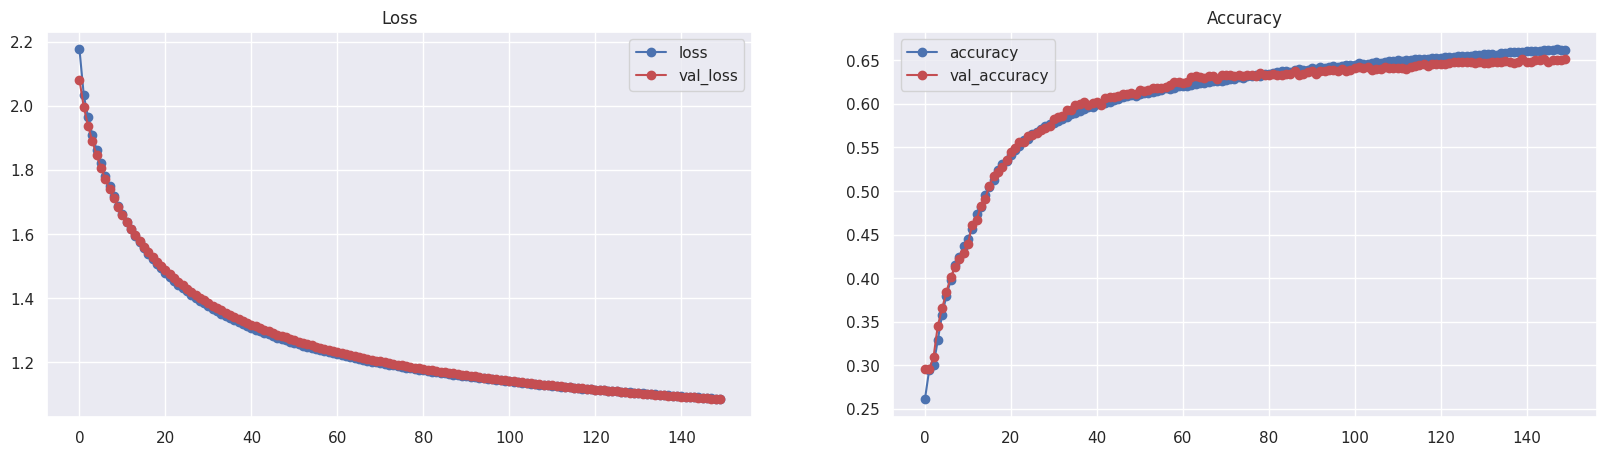

In [28]:
logistic_model_lab = performLogisticRegression(X_lab_train, Y_train, X_lab_val, Y_val)

Epoch 1/20
227/227 [==============================] - 3s 9ms/step - loss: 1.5975 - accuracy: 0.4660 - val_loss: 1.2307 - val_accuracy: 0.5833
Epoch 2/20
227/227 [==============================] - 3s 11ms/step - loss: 1.0890 - accuracy: 0.6346 - val_loss: 0.9431 - val_accuracy: 0.6805
Epoch 3/20
227/227 [==============================] - 3s 13ms/step - loss: 0.9302 - accuracy: 0.6866 - val_loss: 0.7894 - val_accuracy: 0.7351
Epoch 4/20
227/227 [==============================] - 2s 8ms/step - loss: 0.8350 - accuracy: 0.7142 - val_loss: 0.7261 - val_accuracy: 0.7472
Epoch 5/20
227/227 [==============================] - 2s 8ms/step - loss: 0.7711 - accuracy: 0.7350 - val_loss: 0.6875 - val_accuracy: 0.7660
Epoch 6/20
227/227 [==============================] - 2s 8ms/step - loss: 0.7173 - accuracy: 0.7520 - val_loss: 0.6315 - val_accuracy: 0.7792
Epoch 7/20
227/227 [==============================] - 2s 8ms/step - loss: 0.6767 - accuracy: 0.7662 - val_loss: 0.6407 - val_accuracy: 0.7688
Epoc

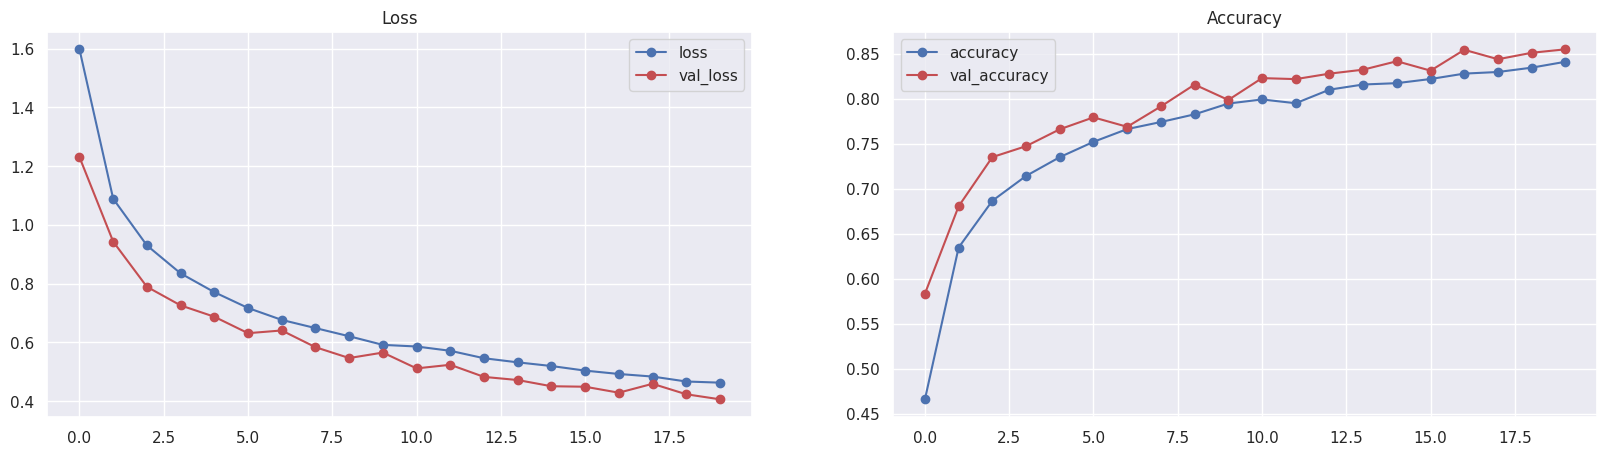

In [29]:
featurenet_model_lab = performFeatureNet(X_lab_train, Y_train, X_lab_val, Y_val)

In [30]:
knn_model_lab = performKnn(X_lab_train, Y_train, X_lab_val, Y_val)

Training Accuracy: 0.84
Validation Accuracy: 0.75


In [31]:
randomforest_model_lab = performRandomForest(X_lab_train, Y_train, X_lab_val, Y_val)

Training Accuracy: 1.00
Validation Accuracy: 0.88


In [32]:
decisiontree_model_lab = performDecisionTree(X_lab_train, Y_train, X_lab_val, Y_val)

Training Accuracy: 1.00
Validation Accuracy: 0.71


#### Comparing Performances

##### Performance Table for RGB

| Model | Training Accuracy | Validation Accuracy |
| --- | --- | --- |
| Logistic Regression | 58.76% | 57.78% |
| FeatureNet | 76.35% | 79.97% |
| KNN | 79% | 68% |
| Random Forest | 100% | 82% |
| Decision Tree | 100% | 65% |

##### Performance Table for LAB

| Model | Training Accuracy | Validation Accuracy |
| --- | --- | --- |
| Logistic Regression | 66.15% | 65.12% |
| FeatureNet | 84.10% | 85.49% |
| KNN | 84% | 75% |
| Random Forest | 100% | 88% |
| Decision Tree | 100% | 71% |

### LAB vs LAB + Daisy

In [33]:
# train
X_lab_daisy_train = read_features_from_files([
    '/content/drive/MyDrive/Tomato Leaf Disease Classification/features/train_labhist_b100_prob.csv',
    '/content/drive/MyDrive/Tomato Leaf Disease Classification/features/train_daisy_s60_rad30_rings3_h6_o8.csv'
])
print('Train:', X_lab_daisy_train.shape, Y_train.shape)

# val
X_lab_daisy_val = read_features_from_files([
    '/content/drive/MyDrive/Tomato Leaf Disease Classification/features/val_labhist_b100_prob.csv',
    '/content/drive/MyDrive/Tomato Leaf Disease Classification/features/val_daisy_s60_rad30_rings3_h6_o8.csv'
])
print('Validation:', X_lab_daisy_val.shape, Y_val.shape)

# test
X_lab_daisy_test = read_features_from_files([
    '/content/drive/MyDrive/Tomato Leaf Disease Classification/features/test_labhist_b100_prob.csv',
    '/content/drive/MyDrive/Tomato Leaf Disease Classification/features/test_daisy_s60_rad30_rings3_h6_o8.csv'
])
print('Test:', X_lab_daisy_test.shape, Y_test.shape)

Train: (14523, 2732) (14523,)
Validation: (1812, 2732) (1812,)
Test: (1824, 2732) (1824,)


#### Train + Validation Performance of LAB + Daisy

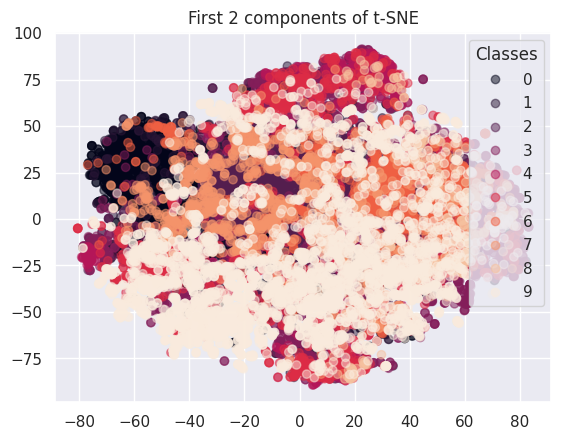

In [34]:
displayTsne(X_lab_daisy_train)

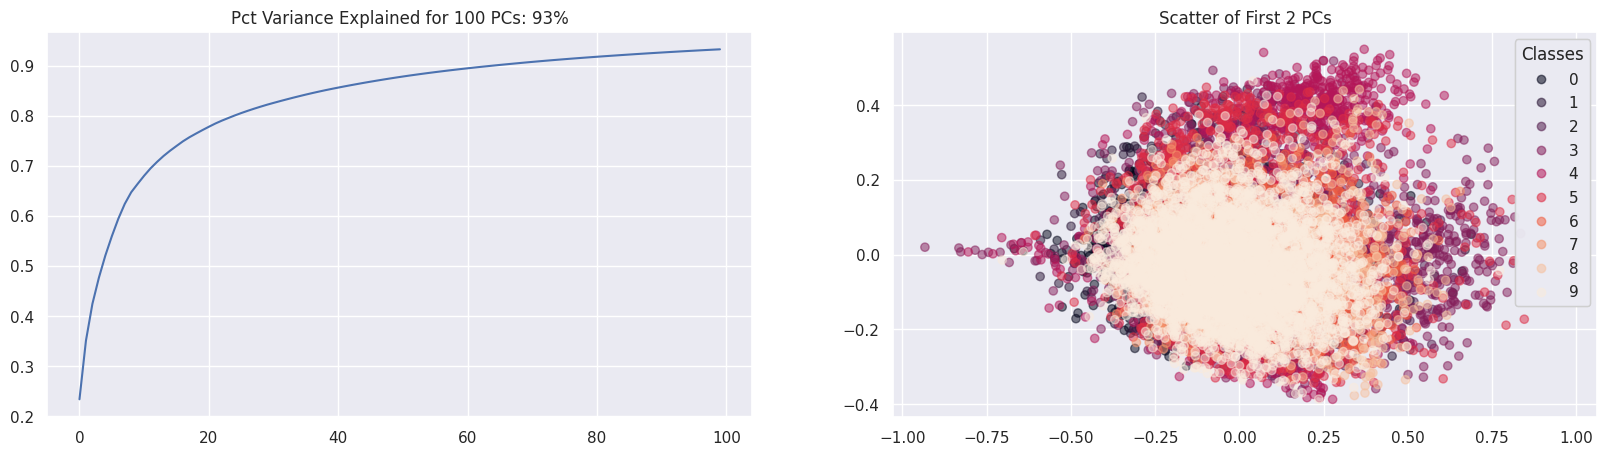

In [36]:
lab_daisy_pca, X_lab_daisy_train_pca = displayPca(X_lab_daisy_train)
X_lab_daisy_val_pca = lab_daisy_pca.transform(X_lab_daisy_val)

Epoch 1/150
227/227 [==============================] - 1s 4ms/step - loss: 1.9887 - accuracy: 0.2948 - val_loss: 1.8468 - val_accuracy: 0.3052
Epoch 2/150
227/227 [==============================] - 1s 3ms/step - loss: 1.7453 - accuracy: 0.3752 - val_loss: 1.6764 - val_accuracy: 0.4476
Epoch 3/150
227/227 [==============================] - 1s 3ms/step - loss: 1.6010 - accuracy: 0.4812 - val_loss: 1.5676 - val_accuracy: 0.5044
Epoch 4/150
227/227 [==============================] - 1s 4ms/step - loss: 1.5034 - accuracy: 0.5219 - val_loss: 1.4872 - val_accuracy: 0.5326
Epoch 5/150
227/227 [==============================] - 1s 5ms/step - loss: 1.4314 - accuracy: 0.5519 - val_loss: 1.4273 - val_accuracy: 0.5497
Epoch 6/150
227/227 [==============================] - 1s 5ms/step - loss: 1.3744 - accuracy: 0.5716 - val_loss: 1.3787 - val_accuracy: 0.5684
Epoch 7/150
227/227 [==============================] - 1s 5ms/step - loss: 1.3275 - accuracy: 0.5892 - val_loss: 1.3381 - val_accuracy: 0.5778

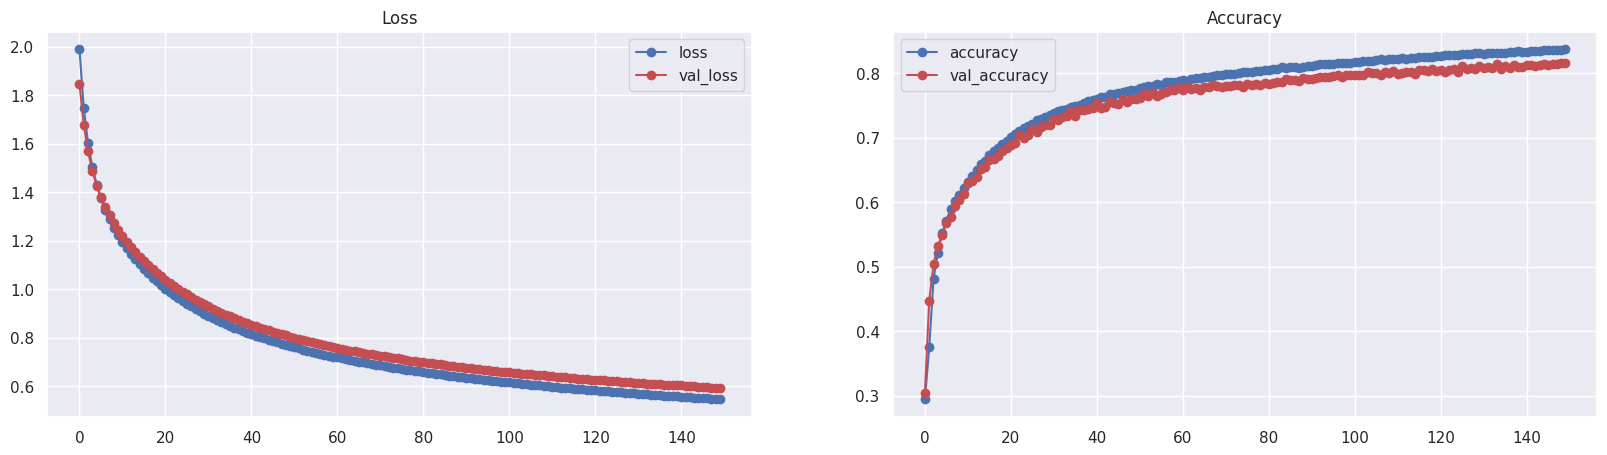

In [37]:
logistic_model_lab_daisy = performLogisticRegression(X_lab_daisy_train, Y_train, X_lab_daisy_val, Y_val)

Epoch 1/20
227/227 [==============================] - 8s 30ms/step - loss: 1.4352 - accuracy: 0.5052 - val_loss: 1.0392 - val_accuracy: 0.6507
Epoch 2/20
227/227 [==============================] - 6s 27ms/step - loss: 0.9068 - accuracy: 0.6961 - val_loss: 0.7490 - val_accuracy: 0.7472
Epoch 3/20
227/227 [==============================] - 6s 25ms/step - loss: 0.7531 - accuracy: 0.7470 - val_loss: 0.6241 - val_accuracy: 0.7842
Epoch 4/20
227/227 [==============================] - 7s 33ms/step - loss: 0.6402 - accuracy: 0.7814 - val_loss: 0.5727 - val_accuracy: 0.8035
Epoch 5/20
227/227 [==============================] - 7s 29ms/step - loss: 0.5851 - accuracy: 0.8025 - val_loss: 0.5399 - val_accuracy: 0.8223
Epoch 6/20
227/227 [==============================] - 7s 31ms/step - loss: 0.5331 - accuracy: 0.8190 - val_loss: 0.4995 - val_accuracy: 0.8344
Epoch 7/20
227/227 [==============================] - 6s 25ms/step - loss: 0.4964 - accuracy: 0.8305 - val_loss: 0.4817 - val_accuracy: 0.8405

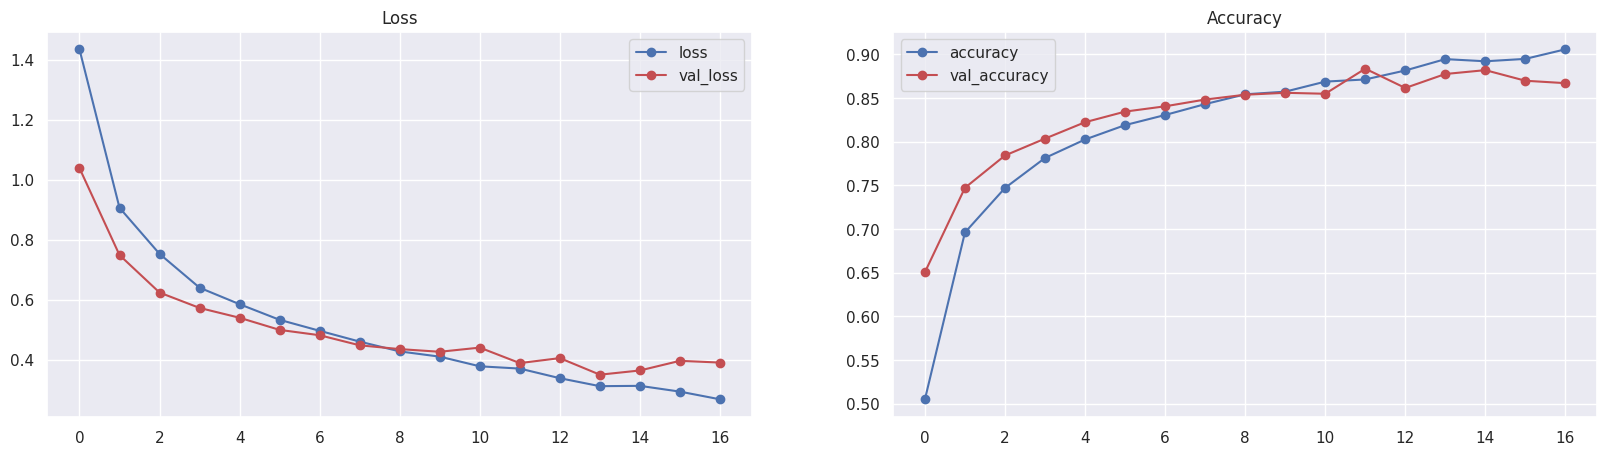

In [38]:
featurenet_model_lab_daisy = performFeatureNet(X_lab_daisy_train, Y_train, X_lab_daisy_val, Y_val)

In [39]:
knn_model_lab_daisy = performKnn(X_lab_daisy_train, Y_train, X_lab_daisy_val, Y_val)

Training Accuracy: 0.80
Validation Accuracy: 0.68


In [40]:
randomforest_model_lab_daisy = performRandomForest(X_lab_daisy_train, Y_train, X_lab_daisy_val, Y_val)

Training Accuracy: 1.00
Validation Accuracy: 0.84


In [41]:
decisiontree_model_lab_daisy = performDecisionTree(X_lab_daisy_train, Y_train, X_lab_daisy_val, Y_val)

Training Accuracy: 1.00
Validation Accuracy: 0.67


#### Comparing Performances

##### Performance Table for LAB

| Model | Training Accuracy | Validation Accuracy |
| --- | --- | --- |
| Logistic Regression | 66.15% | 65.12% |
| FeatureNet | 84.10% | 85.49% |
| KNN | 84% | 75% |
| Random Forest | 100% | 88% |
| Decision Tree | 100% | 71% |

##### Performance Table for LAB + Daisy

| Model | Training Accuracy | Validation Accuracy |
| --- | --- | --- |
| Logistic Regression | 83.72% | 81.57% |
| FeatureNet | 90.57% | 86.70% |
| KNN | 80% | 68% |
| Random Forest | 100% | 84% |
| Decision Tree | 100% | 67% |

### LAB + Daisy vs LAB + Daisy + Canny

In [42]:
# train
X_lab_daisy_canny_train = read_features_from_files([
    '/content/drive/MyDrive/Tomato Leaf Disease Classification/features/train_labhist_b100_prob.csv',
    '/content/drive/MyDrive/Tomato Leaf Disease Classification/features/train_daisy_s60_rad30_rings3_h6_o8.csv',
    '/content/drive/MyDrive/Tomato Leaf Disease Classification/features/train_canny.csv'
])
print('Train:', X_lab_daisy_canny_train.shape, Y_train.shape)

# val
X_lab_daisy_canny_val = read_features_from_files([
    '/content/drive/MyDrive/Tomato Leaf Disease Classification/features/val_labhist_b100_prob.csv',
    '/content/drive/MyDrive/Tomato Leaf Disease Classification/features/val_daisy_s60_rad30_rings3_h6_o8.csv',
    '/content/drive/MyDrive/Tomato Leaf Disease Classification/features/val_canny.csv'
])
print('Validation:', X_lab_daisy_canny_val.shape, Y_val.shape)

# test
X_lab_daisy_canny_test = read_features_from_files([
    '/content/drive/MyDrive/Tomato Leaf Disease Classification/features/test_labhist_b100_prob.csv',
    '/content/drive/MyDrive/Tomato Leaf Disease Classification/features/test_daisy_s60_rad30_rings3_h6_o8.csv',
    '/content/drive/MyDrive/Tomato Leaf Disease Classification/features/test_canny.csv'
])
print('Test:', X_lab_daisy_canny_test.shape, Y_test.shape)

Train: (14523, 2734) (14523,)
Validation: (1812, 2734) (1812,)
Test: (1824, 2734) (1824,)


#### Train + Validation Performance of LAB + Daisy + Canny

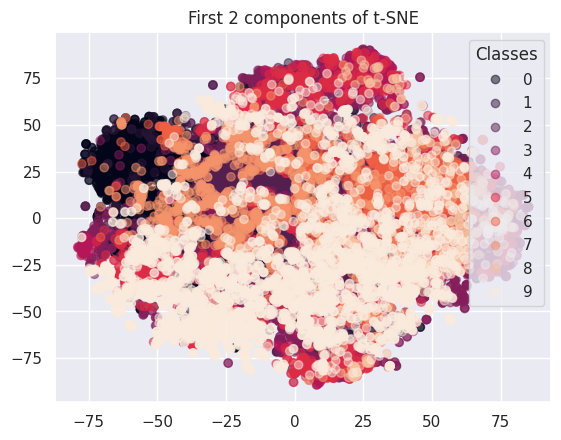

In [43]:
displayTsne(X_lab_daisy_canny_train)

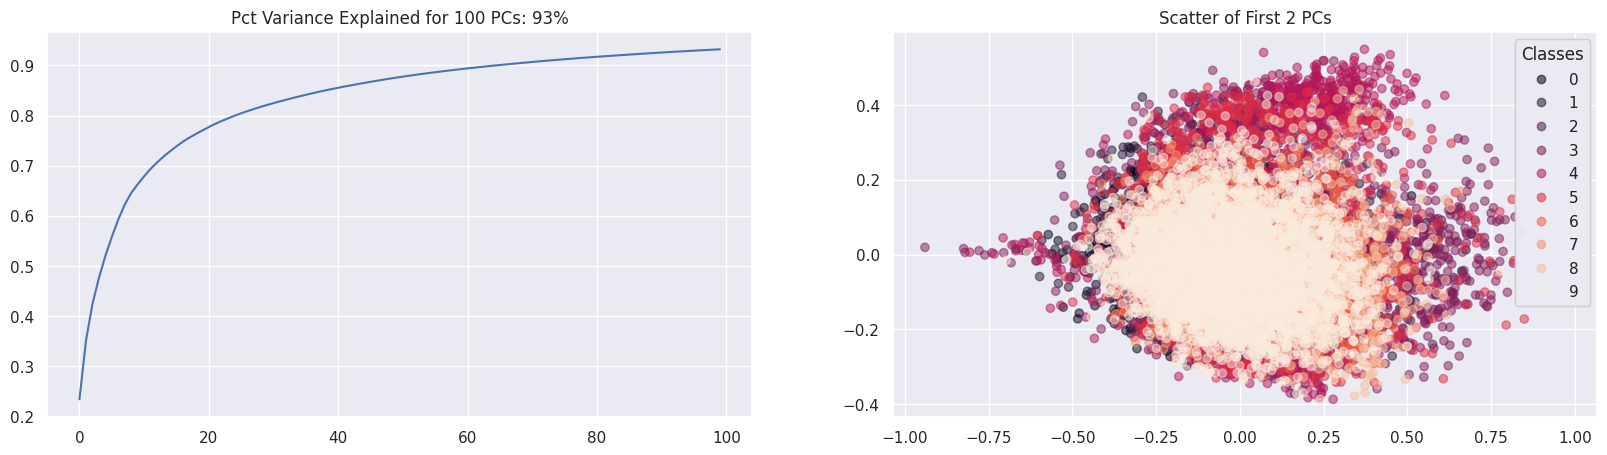

In [45]:
lab_daisy_canny_pca, X_lab_daisy_canny_train_pca = displayPca(X_lab_daisy_canny_train)
X_lab_daisy_canny_val_pca = lab_daisy_canny_pca.transform(X_lab_daisy_canny_val)

Epoch 1/150
227/227 [==============================] - 1s 4ms/step - loss: 1.9921 - accuracy: 0.2928 - val_loss: 1.8500 - val_accuracy: 0.3118
Epoch 2/150
227/227 [==============================] - 1s 3ms/step - loss: 1.7483 - accuracy: 0.3773 - val_loss: 1.6782 - val_accuracy: 0.4216
Epoch 3/150
227/227 [==============================] - 1s 3ms/step - loss: 1.6029 - accuracy: 0.4783 - val_loss: 1.5663 - val_accuracy: 0.4906
Epoch 4/150
227/227 [==============================] - 1s 3ms/step - loss: 1.5037 - accuracy: 0.5226 - val_loss: 1.4880 - val_accuracy: 0.5408
Epoch 5/150
227/227 [==============================] - 1s 3ms/step - loss: 1.4313 - accuracy: 0.5522 - val_loss: 1.4270 - val_accuracy: 0.5530
Epoch 6/150
227/227 [==============================] - 1s 3ms/step - loss: 1.3741 - accuracy: 0.5744 - val_loss: 1.3778 - val_accuracy: 0.5640
Epoch 7/150
227/227 [==============================] - 1s 3ms/step - loss: 1.3266 - accuracy: 0.5900 - val_loss: 1.3383 - val_accuracy: 0.5833

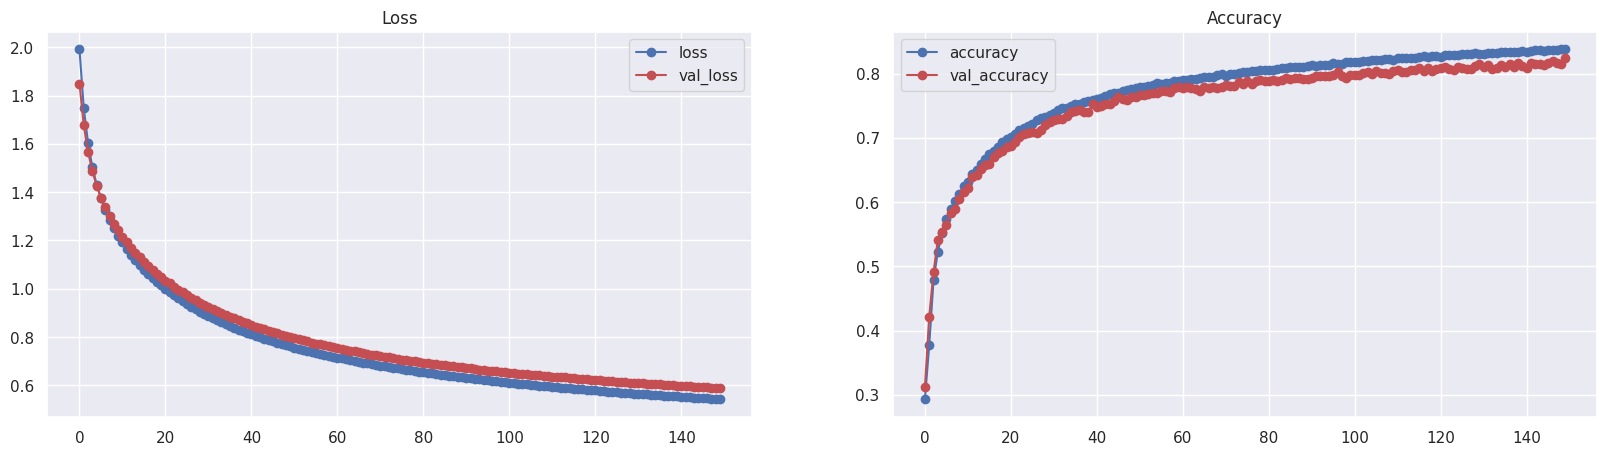

In [46]:
logistic_model_lab_daisy_canny = performLogisticRegression(X_lab_daisy_canny_train, Y_train, X_lab_daisy_canny_val, Y_val)

Epoch 1/20
227/227 [==============================] - 8s 32ms/step - loss: 1.4050 - accuracy: 0.5192 - val_loss: 0.9872 - val_accuracy: 0.6639
Epoch 2/20
227/227 [==============================] - 6s 25ms/step - loss: 0.8901 - accuracy: 0.6983 - val_loss: 0.7617 - val_accuracy: 0.7384
Epoch 3/20
227/227 [==============================] - 7s 30ms/step - loss: 0.7340 - accuracy: 0.7510 - val_loss: 0.6876 - val_accuracy: 0.7643
Epoch 4/20
227/227 [==============================] - 6s 26ms/step - loss: 0.6496 - accuracy: 0.7797 - val_loss: 0.5685 - val_accuracy: 0.8107
Epoch 5/20
227/227 [==============================] - 6s 25ms/step - loss: 0.5825 - accuracy: 0.8000 - val_loss: 0.5157 - val_accuracy: 0.8322
Epoch 6/20
227/227 [==============================] - 7s 32ms/step - loss: 0.5335 - accuracy: 0.8164 - val_loss: 0.5096 - val_accuracy: 0.8262
Epoch 7/20
227/227 [==============================] - 6s 25ms/step - loss: 0.5003 - accuracy: 0.8283 - val_loss: 0.4770 - val_accuracy: 0.8383

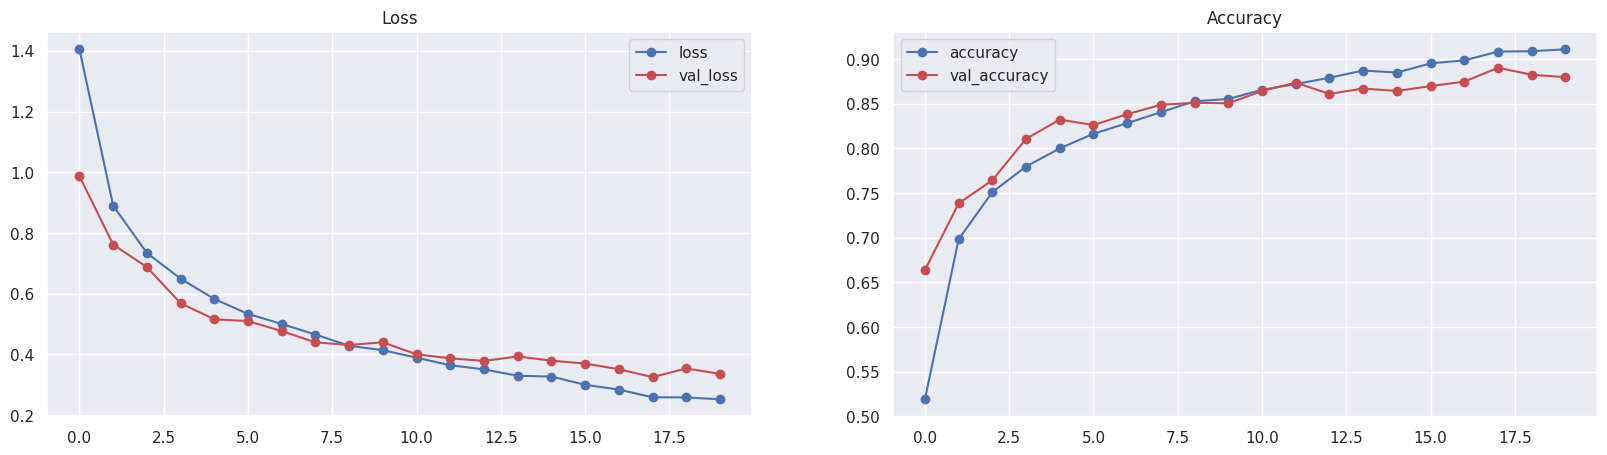

In [47]:
featurenet_model_lab_daisy_canny = performFeatureNet(X_lab_daisy_canny_train, Y_train, X_lab_daisy_canny_val, Y_val)

In [48]:
knn_model_lab_daisy_canny = performKnn(X_lab_daisy_canny_train, Y_train, X_lab_daisy_canny_val, Y_val)

Training Accuracy: 0.81
Validation Accuracy: 0.69


In [49]:
randomforest_model_lab_daisy_canny = performRandomForest(X_lab_daisy_canny_train, Y_train, X_lab_daisy_canny_val, Y_val)

Training Accuracy: 1.00
Validation Accuracy: 0.85


In [50]:
decisiontree_model_lab_daisy_canny = performDecisionTree(X_lab_daisy_canny_train, Y_train, X_lab_daisy_canny_val, Y_val)

Training Accuracy: 1.00
Validation Accuracy: 0.69


#### Comparing Performances

##### Performance Table for LAB + Daisy

| Model | Training Accuracy | Validation Accuracy |
| --- | --- | --- |
| Logistic Regression | 83.72% | 81.57% |
| FeatureNet | 90.57% | 86.70% |
| KNN | 80% | 68% |
| Random Forest | 100% | 84% |
| Decision Tree | 100% | 67% |

##### Performance Table for LAB + Daisy + Canny

| Model | Training Accuracy | Validation Accuracy |
| --- | --- | --- |
| Logistic Regression | 83.81% | 82.45% |
| FeatureNet | 91.09% | 87.97% |
| KNN | 81% | 69% |
| Random Forest | 100% | 85% |
| Decision Tree | 100% | 69% |

### LAB + Daisy + Canny vs LAB + Daisy + Canny + Blob

In [51]:
# train
X_lab_daisy_canny_blob_train = read_features_from_files([
    '/content/drive/MyDrive/Tomato Leaf Disease Classification/features/train_labhist_b100_prob.csv',
    '/content/drive/MyDrive/Tomato Leaf Disease Classification/features/train_daisy_s60_rad30_rings3_h6_o8.csv',
    '/content/drive/MyDrive/Tomato Leaf Disease Classification/features/train_canny.csv',
    '/content/drive/MyDrive/Tomato Leaf Disease Classification/features/train_blob.csv'
])
print('Train:', X_lab_daisy_canny_blob_train.shape, Y_train.shape)

# val
X_lab_daisy_canny_blob_val = read_features_from_files([
    '/content/drive/MyDrive/Tomato Leaf Disease Classification/features/val_labhist_b100_prob.csv',
    '/content/drive/MyDrive/Tomato Leaf Disease Classification/features/val_daisy_s60_rad30_rings3_h6_o8.csv',
    '/content/drive/MyDrive/Tomato Leaf Disease Classification/features/val_canny.csv',
    '/content/drive/MyDrive/Tomato Leaf Disease Classification/features/val_blob.csv'
])
print('Validation:', X_lab_daisy_canny_blob_val.shape, Y_val.shape)

# test
X_lab_daisy_canny_blob_test = read_features_from_files([
    '/content/drive/MyDrive/Tomato Leaf Disease Classification/features/test_labhist_b100_prob.csv',
    '/content/drive/MyDrive/Tomato Leaf Disease Classification/features/test_daisy_s60_rad30_rings3_h6_o8.csv',
    '/content/drive/MyDrive/Tomato Leaf Disease Classification/features/test_canny.csv',
    '/content/drive/MyDrive/Tomato Leaf Disease Classification/features/test_blob.csv'
])
print('Test:', X_lab_daisy_canny_blob_test.shape, Y_test.shape)

Train: (14523, 2754) (14523,)
Validation: (1812, 2754) (1812,)
Test: (1824, 2754) (1824,)


#### Train + Validation Performance of LAB + Daisy + Canny + Blob

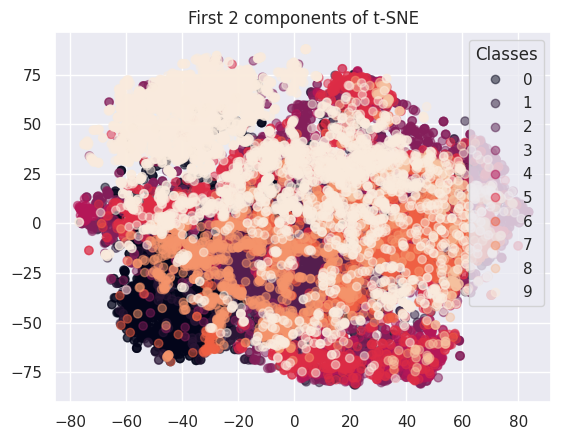

In [52]:
displayTsne(X_lab_daisy_canny_blob_train)

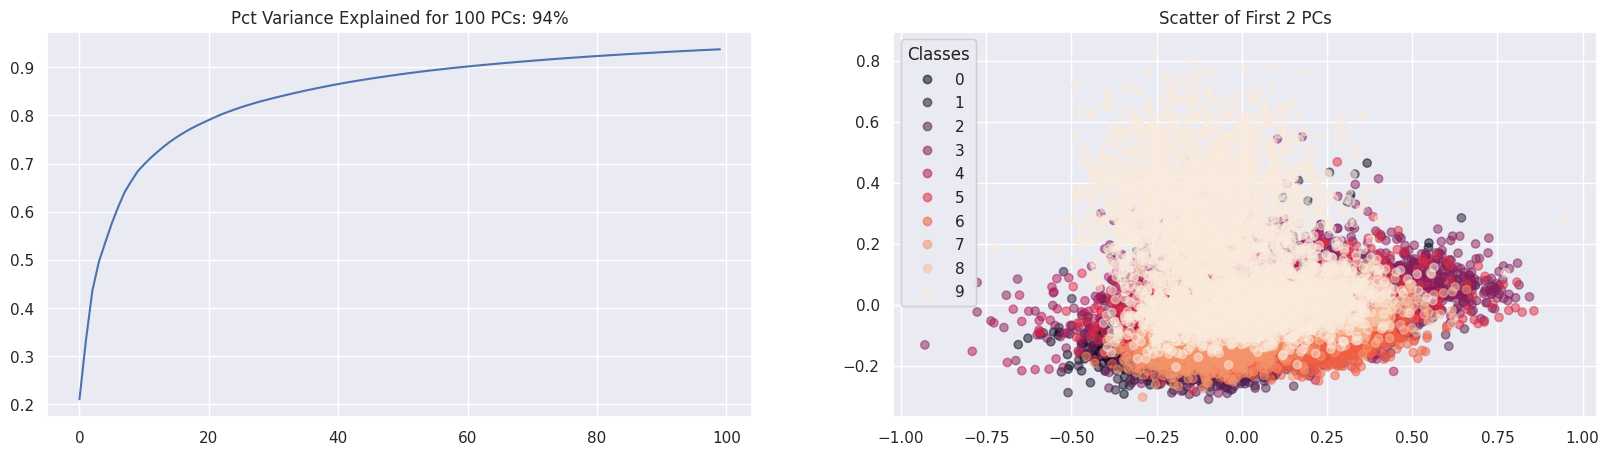

In [53]:
lab_daisy_canny_blob_pca, X_lab_daisy_canny_blob_train_pca = displayPca(X_lab_daisy_canny_blob_train)
X_lab_daisy_canny_blob_val_pca = lab_daisy_canny_blob_pca.transform(X_lab_daisy_canny_blob_val)

Epoch 1/150
227/227 [==============================] - 1s 4ms/step - loss: 1.9793 - accuracy: 0.2949 - val_loss: 1.8349 - val_accuracy: 0.3063
Epoch 2/150
227/227 [==============================] - 1s 4ms/step - loss: 1.7280 - accuracy: 0.3862 - val_loss: 1.6563 - val_accuracy: 0.4536
Epoch 3/150
227/227 [==============================] - 2s 10ms/step - loss: 1.5782 - accuracy: 0.4916 - val_loss: 1.5411 - val_accuracy: 0.5199
Epoch 4/150
227/227 [==============================] - 1s 4ms/step - loss: 1.4771 - accuracy: 0.5379 - val_loss: 1.4598 - val_accuracy: 0.5419
Epoch 5/150
227/227 [==============================] - 1s 4ms/step - loss: 1.4022 - accuracy: 0.5668 - val_loss: 1.3976 - val_accuracy: 0.5690
Epoch 6/150
227/227 [==============================] - 1s 3ms/step - loss: 1.3434 - accuracy: 0.5881 - val_loss: 1.3473 - val_accuracy: 0.5855
Epoch 7/150
227/227 [==============================] - 1s 3ms/step - loss: 1.2946 - accuracy: 0.6045 - val_loss: 1.3046 - val_accuracy: 0.602

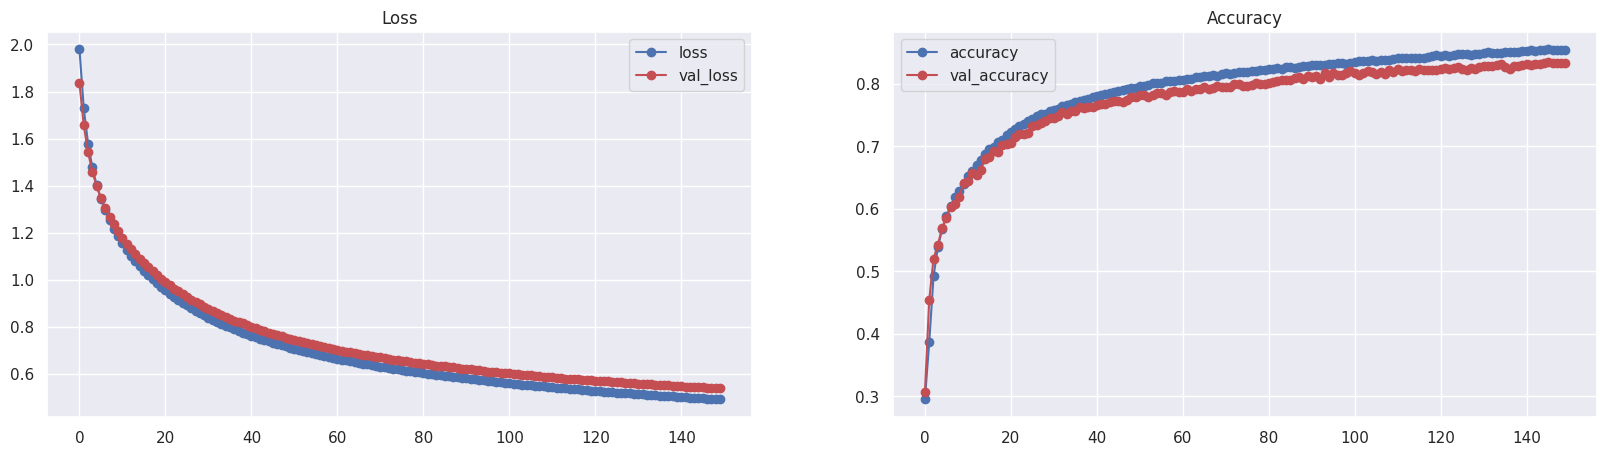

In [54]:
logistic_model_lab_daisy_canny_blob = performLogisticRegression(X_lab_daisy_canny_blob_train, Y_train, X_lab_daisy_canny_blob_val, Y_val)

Epoch 1/20
227/227 [==============================] - 8s 31ms/step - loss: 1.3817 - accuracy: 0.5281 - val_loss: 1.0180 - val_accuracy: 0.6600
Epoch 2/20
227/227 [==============================] - 6s 27ms/step - loss: 0.8307 - accuracy: 0.7189 - val_loss: 0.7149 - val_accuracy: 0.7555
Epoch 3/20
227/227 [==============================] - 6s 25ms/step - loss: 0.6771 - accuracy: 0.7698 - val_loss: 0.5921 - val_accuracy: 0.8024
Epoch 4/20
227/227 [==============================] - 8s 34ms/step - loss: 0.6003 - accuracy: 0.7933 - val_loss: 0.5948 - val_accuracy: 0.7969
Epoch 5/20
227/227 [==============================] - 6s 26ms/step - loss: 0.5373 - accuracy: 0.8123 - val_loss: 0.4896 - val_accuracy: 0.8300
Epoch 6/20
227/227 [==============================] - 7s 32ms/step - loss: 0.4975 - accuracy: 0.8307 - val_loss: 0.4732 - val_accuracy: 0.8366
Epoch 7/20
227/227 [==============================] - 6s 25ms/step - loss: 0.4602 - accuracy: 0.8381 - val_loss: 0.5456 - val_accuracy: 0.8129

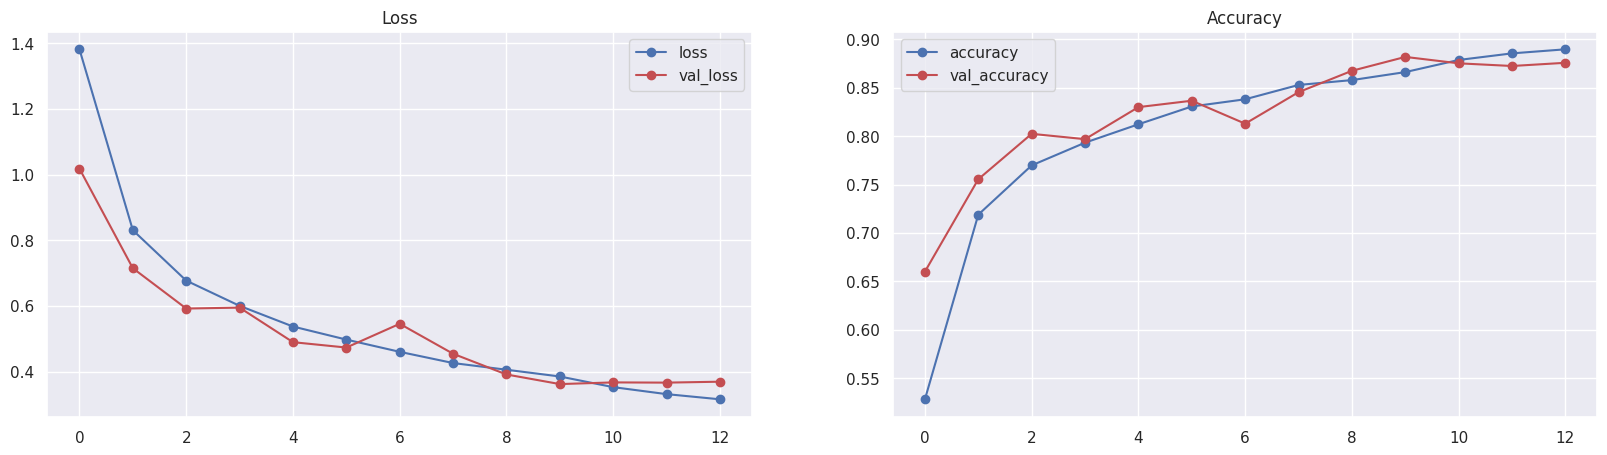

In [55]:
featurenet_model_lab_daisy_canny_blob = performFeatureNet(X_lab_daisy_canny_blob_train, Y_train, X_lab_daisy_canny_blob_val, Y_val)

In [56]:
knn_model_lab_daisy_canny_blob = performKnn(X_lab_daisy_canny_blob_train, Y_train, X_lab_daisy_canny_blob_val, Y_val)

Training Accuracy: 0.83
Validation Accuracy: 0.72


In [57]:
randomforest_model_lab_daisy_canny_blob = performRandomForest(X_lab_daisy_canny_blob_train, Y_train, X_lab_daisy_canny_blob_val, Y_val)

Training Accuracy: 1.00
Validation Accuracy: 0.85


In [58]:
decisiontree_model_lab_daisy_canny_blob = performDecisionTree(X_lab_daisy_canny_blob_train, Y_train, X_lab_daisy_canny_blob_val, Y_val)

Training Accuracy: 1.00
Validation Accuracy: 0.69


#### Comparing Performances

##### Performance Table for LAB + Daisy + Canny

| Model | Training Accuracy | Validation Accuracy |
| --- | --- | --- |
| Logistic Regression | 83.81% | 82.45% |
| FeatureNet | 91.09% | 87.97% |
| KNN | 81% | 69% |
| Random Forest | 100% | 85% |
| Decision Tree | 100% | 69% |

##### Performance Table for LAB + Daisy + Canny + Blob

| Model | Training Accuracy | Validation Accuracy |
| --- | --- | --- |
| Logistic Regression | 85.40% | 83.33% |
| FeatureNet | 88.98% | 87.58% |
| KNN | 83% | 72% |
| Random Forest | 100% | 85% |
| Decision Tree | 100% | 69% |

### LAB + Daisy + Canny + Blob vs First 60 PCs of Its PCA

#### Train + Validation Performance of First 60 PCs of PCA for LAB + Daisy + Canny + Blob

Epoch 1/150
227/227 [==============================] - 2s 3ms/step - loss: 2.2185 - accuracy: 0.3242 - val_loss: 2.1487 - val_accuracy: 0.3902
Epoch 2/150
227/227 [==============================] - 0s 2ms/step - loss: 2.0847 - accuracy: 0.3773 - val_loss: 2.0301 - val_accuracy: 0.3764
Epoch 3/150
227/227 [==============================] - 0s 2ms/step - loss: 1.9754 - accuracy: 0.3691 - val_loss: 1.9338 - val_accuracy: 0.3653
Epoch 4/150
227/227 [==============================] - 0s 2ms/step - loss: 1.8859 - accuracy: 0.3698 - val_loss: 1.8548 - val_accuracy: 0.3714
Epoch 5/150
227/227 [==============================] - 0s 2ms/step - loss: 1.8119 - accuracy: 0.3804 - val_loss: 1.7886 - val_accuracy: 0.3825
Epoch 6/150
227/227 [==============================] - 0s 2ms/step - loss: 1.7491 - accuracy: 0.3996 - val_loss: 1.7318 - val_accuracy: 0.4045
Epoch 7/150
227/227 [==============================] - 1s 3ms/step - loss: 1.6942 - accuracy: 0.4232 - val_loss: 1.6816 - val_accuracy: 0.4277

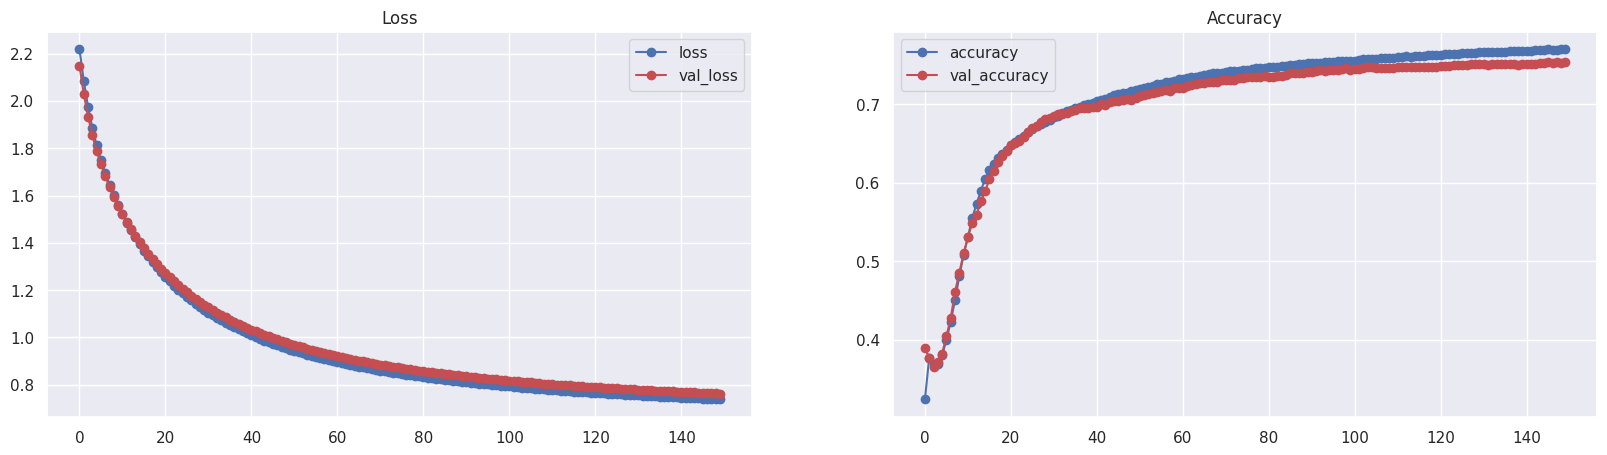

In [59]:
logistic_model_lab_daisy_canny_blob_pca = performLogisticRegression(X_lab_daisy_canny_blob_train_pca[:, :60], Y_train, X_lab_daisy_canny_blob_val_pca[:, :60], Y_val)

Epoch 1/20
227/227 [==============================] - 3s 8ms/step - loss: 1.2307 - accuracy: 0.5899 - val_loss: 0.8102 - val_accuracy: 0.7340
Epoch 2/20
227/227 [==============================] - 2s 7ms/step - loss: 0.7591 - accuracy: 0.7470 - val_loss: 0.6788 - val_accuracy: 0.7826
Epoch 3/20
227/227 [==============================] - 2s 7ms/step - loss: 0.6575 - accuracy: 0.7811 - val_loss: 0.6280 - val_accuracy: 0.7892
Epoch 4/20
227/227 [==============================] - 2s 7ms/step - loss: 0.5798 - accuracy: 0.8069 - val_loss: 0.5480 - val_accuracy: 0.8146
Epoch 5/20
227/227 [==============================] - 2s 7ms/step - loss: 0.5195 - accuracy: 0.8271 - val_loss: 0.5013 - val_accuracy: 0.8240
Epoch 6/20
227/227 [==============================] - 2s 10ms/step - loss: 0.4692 - accuracy: 0.8459 - val_loss: 0.4579 - val_accuracy: 0.8438
Epoch 7/20
227/227 [==============================] - 2s 11ms/step - loss: 0.4337 - accuracy: 0.8546 - val_loss: 0.4331 - val_accuracy: 0.8565
Epoc

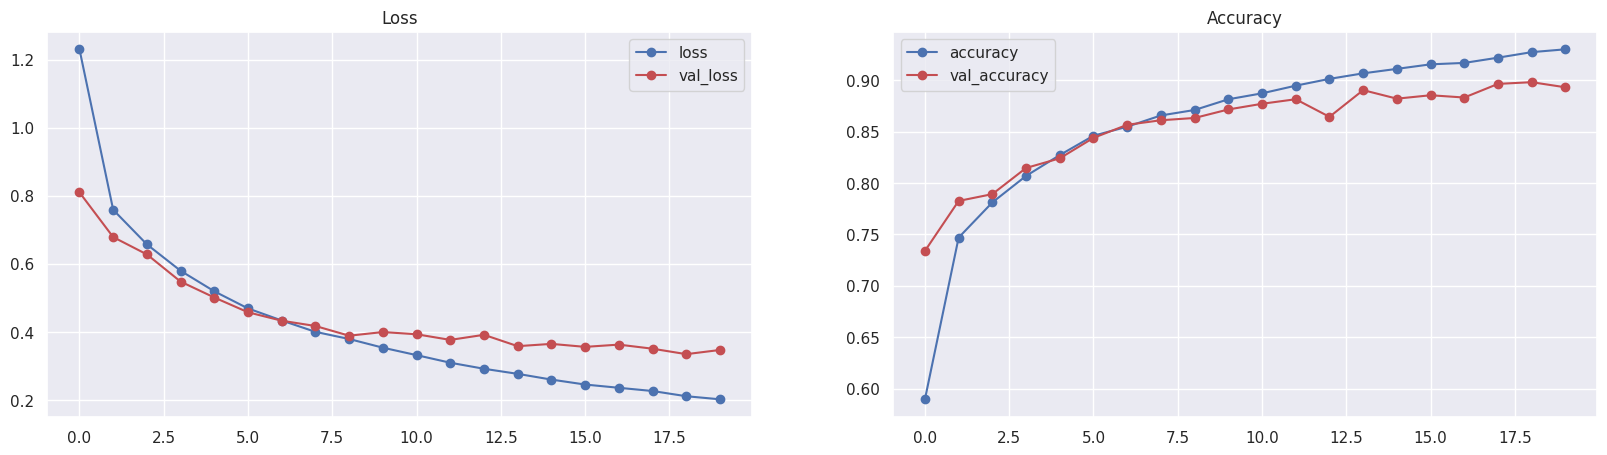

In [64]:
featurenet_model_lab_daisy_canny_blob_pca = performFeatureNet(X_lab_daisy_canny_blob_train_pca[:, :60], Y_train, X_lab_daisy_canny_blob_val_pca[:, :60], Y_val)

In [61]:
knn_model_lab_daisy_canny_blob_pca = performKnn(X_lab_daisy_canny_blob_train_pca[:, :60], Y_train, X_lab_daisy_canny_blob_val_pca[:, :60], Y_val)

Training Accuracy: 0.82
Validation Accuracy: 0.71


In [62]:
randomforest_model_lab_daisy_canny_blob_pca = performRandomForest(X_lab_daisy_canny_blob_train_pca[:, :60], Y_train, X_lab_daisy_canny_blob_val_pca[:, :60], Y_val)

Training Accuracy: 1.00
Validation Accuracy: 0.75


In [63]:
decisiontree_model_lab_daisy_canny_blob_pca = performDecisionTree(X_lab_daisy_canny_blob_train_pca[:, :60], Y_train, X_lab_daisy_canny_blob_val_pca[:, :60], Y_val)

Training Accuracy: 1.00
Validation Accuracy: 0.57


#### Comparing Performances

##### Performance Table for LAB + Daisy + Canny + Blob

| Model | Training Accuracy | Validation Accuracy |
| --- | --- | --- |
| Logistic Regression | 85.40% | 83.33% |
| FeatureNet | 88.98% | 87.58% |
| KNN | 83% | 72% |
| Random Forest | 100% | 85% |
| Decision Tree | 100% | 69% |

##### Performance Table for First 60 PCs of PCA for LAB + Daisy + Canny + Blob

| Model | Training Accuracy | Validation Accuracy |
| --- | --- | --- |
| Logistic Regression | 76.97% | 75.33% |
| FeatureNet | 92.98% | 89.29% |
| KNN | 82% | 71% |
| Random Forest | 100% | 75% |
| Decision Tree | 100% | 57% |

## Peformance of Test Data for Feature Vector of LAB + Daisy + Canny + Blob

In [70]:
def plotConfusionMatrix(predictions, labels):
  cm = confusion_matrix(labels, predictions)
  sns.heatmap(cm, annot=True, fmt="d", square=True)
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title('Confusion Matrix')
  plt.show()

### Logistic Regression Results

In [66]:
logistic_pred_probas = logistic_model_lab_daisy_canny_blob.predict(X_lab_daisy_canny_blob_test, verbose=0)
logistic_preds = logistic_pred_probas.argmax(axis=1)

print(f'Test Accuracy: {accuracy_score(logistic_preds, Y_test):.2%}\n')

Test Accuracy: 83.11%



In [67]:
print(classification_report(logistic_preds, Y_test))

              precision    recall  f1-score   support

           0       0.90      0.84      0.87       231
           1       0.37      0.61      0.46        61
           2       0.89      0.84      0.86       170
           3       0.76      0.75      0.75       194
           4       0.77      0.80      0.79        92
           5       0.82      0.80      0.81       182
           6       0.80      0.76      0.78       176
           7       0.74      0.77      0.75       135
           8       0.84      0.89      0.86        36
           9       0.95      0.93      0.94       547

    accuracy                           0.83      1824
   macro avg       0.78      0.80      0.79      1824
weighted avg       0.84      0.83      0.84      1824



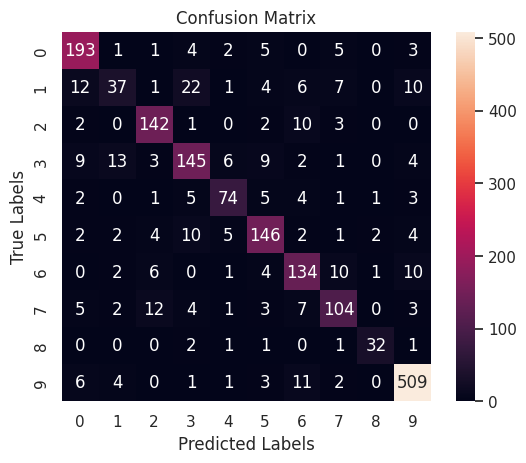

In [71]:
plotConfusionMatrix(logistic_preds, Y_test)

### FeatureNet Results

In [72]:
featurenet_pred_probas = featurenet_model_lab_daisy_canny_blob.predict(X_lab_daisy_canny_blob_test, verbose=0)
featurenet_preds = featurenet_pred_probas.argmax(axis=1)

print(f'Test Accuracy: {accuracy_score(featurenet_preds, Y_test):.2%}\n')

Test Accuracy: 85.96%



In [73]:
print(classification_report(featurenet_preds, Y_test))

              precision    recall  f1-score   support

           0       0.97      0.83      0.89       251
           1       0.29      0.64      0.40        45
           2       0.89      0.89      0.89       160
           3       0.82      0.75      0.78       210
           4       0.66      0.94      0.77        67
           5       0.83      0.86      0.84       173
           6       0.83      0.89      0.86       157
           7       0.89      0.73      0.80       172
           8       0.79      0.91      0.85        33
           9       0.98      0.94      0.96       556

    accuracy                           0.86      1824
   macro avg       0.79      0.84      0.81      1824
weighted avg       0.88      0.86      0.87      1824



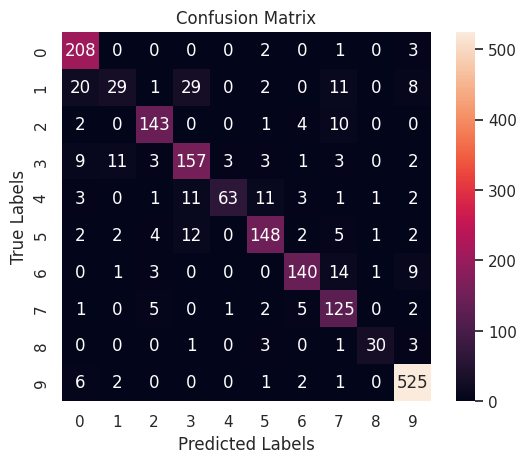

In [74]:
plotConfusionMatrix(featurenet_preds, Y_test)

### KNN Results

In [75]:
knn_preds = knn_model_lab_daisy_canny_blob.predict(X_lab_daisy_canny_blob_test)

print(f'Test Accuracy: {accuracy_score(knn_preds, Y_test):.2%}\n')

Test Accuracy: 72.64%



In [76]:
print(classification_report(knn_preds, Y_test))

              precision    recall  f1-score   support

           0       0.80      0.81      0.81       212
           1       0.24      0.44      0.31        54
           2       0.82      0.75      0.79       176
           3       0.59      0.74      0.66       152
           4       0.72      0.66      0.69       105
           5       0.54      0.80      0.65       121
           6       0.83      0.54      0.65       257
           7       0.57      0.66      0.61       122
           8       0.50      0.68      0.58        28
           9       0.89      0.80      0.85       597

    accuracy                           0.73      1824
   macro avg       0.65      0.69      0.66      1824
weighted avg       0.76      0.73      0.73      1824



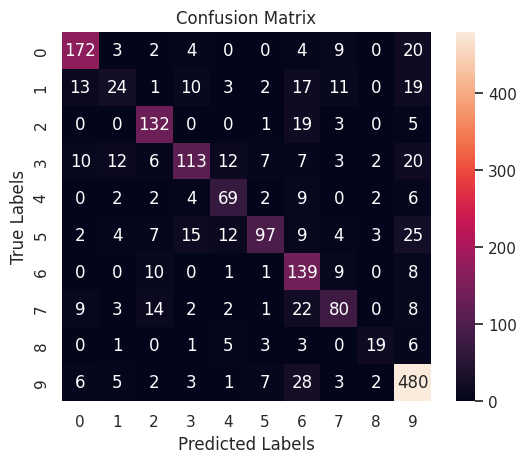

In [77]:
plotConfusionMatrix(knn_preds, Y_test)

### Random Forest Results

In [78]:
randomforest_preds = randomforest_model_lab_daisy_canny_blob.predict(X_lab_daisy_canny_blob_test)

print(f'Test Accuracy: {accuracy_score(randomforest_preds, Y_test):.2%}\n')

Test Accuracy: 85.42%



In [79]:
print(classification_report(randomforest_preds, Y_test))

              precision    recall  f1-score   support

           0       0.93      0.88      0.90       225
           1       0.41      0.71      0.52        58
           2       0.89      0.89      0.89       161
           3       0.82      0.79      0.80       201
           4       0.74      0.84      0.78        85
           5       0.79      0.85      0.82       164
           6       0.82      0.77      0.80       179
           7       0.79      0.79      0.79       141
           8       0.79      0.86      0.82        35
           9       0.98      0.92      0.95       575

    accuracy                           0.85      1824
   macro avg       0.80      0.83      0.81      1824
weighted avg       0.87      0.85      0.86      1824



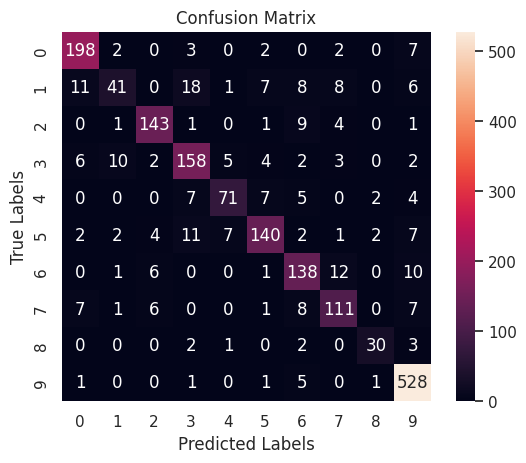

In [80]:
plotConfusionMatrix(randomforest_preds, Y_test)

### Decision Tree Results

In [82]:
decisiontree_preds = decisiontree_model_lab_daisy_canny_blob.predict(X_lab_daisy_canny_blob_test)

print(f'Test Accuracy: {accuracy_score(decisiontree_preds, Y_test):.2%}\n')

Test Accuracy: 72.37%



In [83]:
print(classification_report(decisiontree_preds, Y_test))

              precision    recall  f1-score   support

           0       0.78      0.72      0.75       230
           1       0.44      0.41      0.42       108
           2       0.74      0.78      0.76       152
           3       0.62      0.62      0.62       193
           4       0.61      0.65      0.63        91
           5       0.57      0.65      0.61       156
           6       0.77      0.62      0.69       208
           7       0.50      0.58      0.54       120
           8       0.55      0.70      0.62        30
           9       0.91      0.91      0.91       536

    accuracy                           0.72      1824
   macro avg       0.65      0.67      0.66      1824
weighted avg       0.73      0.72      0.72      1824



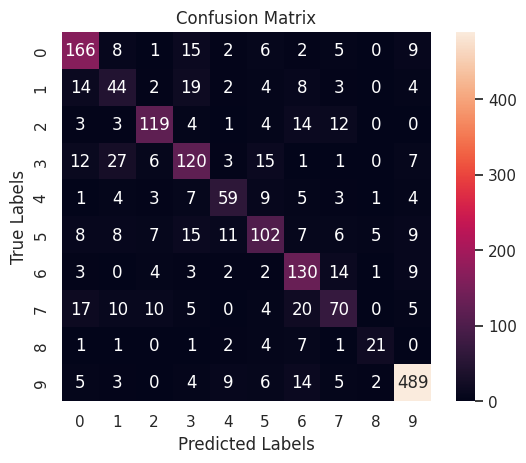

In [84]:
plotConfusionMatrix(decisiontree_preds, Y_test)

## Complete Performance Table for LAB + Daisy + Canny + Blob

| Model | Training Accuracy | Validation Accuracy | Test Accuracy |
| --- | --- | --- | --- |
| Logistic Regression | 85.40% | 83.33% | 83.11% |
| FeatureNet | 88.98% | 87.58% | 85.96% |
| KNN | 83% | 72% | 72.64% |
| Random Forest | 100% | 85% | 85.42% |
| Decision Tree | 100% | 69% | 72.37% |